## Import Packages

In [23]:
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import Ridge

## Read File

In [24]:
data = pd.read_csv('OnlineNewsPopularity.csv')
data.columns = [col.strip() for col in data.columns]


## Create isolation forest model to remove outliers
[API Link to IF](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html#sklearn.ensemble.IsolationForest)

In [25]:
old_data_length = len(data)
IF_model = IsolationForest(contamination=0.1) # Remove 10% data
outliers = IF_model.fit_predict(data.drop(columns=['url', 'timedelta', 'shares'])) # Delete columns than don't need in IF and train IF model
data['outliers'] = outliers

# Remove outliers
data_outliers = data[data['outliers'] == -1]
new_data = data[data['outliers'] != -1].drop(columns = ['outliers'])

new_data_len = len(new_data)

print(f"There are total {old_data_length - new_data_len} rows been removied.")


There are total 3965 rows been removied.


## Creat a function to classify an article to different categories
* Great Article: Shares >= 90%
* Good Article: 70% <= Shares < 90%
* Normal Article: 30% <= Shares < 70%
* Bad article: Shares < 30%

In [26]:
def article_classifier(shares, top_percent):
    if shares >= top_percent[0.9]:
        return 'Great'
    elif shares >= top_percent[0.7]:
        return 'Good'
    elif shares >= top_percent[0.3]:
        return 'Normal'
    else:
        return 'Bad'


## Data Classifier

In [27]:
top_percent = new_data['shares'].quantile([0.3, 0.7, 0.9])

quality = []
for index, row in new_data.iterrows():
    quality.append(article_classifier(row['shares'], top_percent))

new_data['quality'] = quality


## Split dataset into x and y and one-hot encode quality column

In [28]:
x = new_data.drop(columns=['quality', 'url', 'timedelta', 'shares'], axis=1)
y = OneHotEncoder().fit_transform(new_data[['quality']]).toarray()


## Scale the data to Improve the speed of training Model

In [29]:
!pip install matplotlib

In [30]:

from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt


scaler = MinMaxScaler()
scaled_X = scaler.fit_transform(x)


xTrain, xTest, yTrain, yTest = train_test_split(scaled_X, y, test_size=0.2, random_state=10)
print("range of the xTrain:")
print(xTrain.max() - xTrain.min())




range of the xTrain:
1.0


In [31]:

import pandas as pd
scale_xTrain = pd.DataFrame(xTrain)
scale_xTest = pd.DataFrame(xTest)


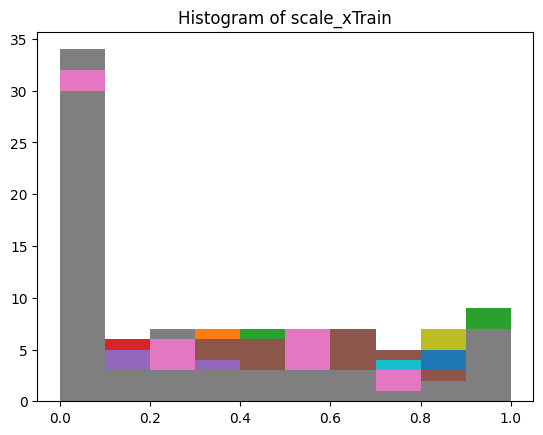

In [32]:
for i in scale_xTrain.columns:
    plt.hist(xTrain[i])
plt.title("Histogram of scale_xTrain")
plt.show()

## Create and train model(NN)

In [33]:
def build_nn_model(input_shape, num_classes):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(128, activation='relu', input_shape=input_shape),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

mirror_strategy = tf.distribute.MirroredStrategy()
with mirror_strategy.scope():
    nn_model1 = build_nn_model(scale_xTrain.shape[1:], yTrain.shape[1])
    nn_model2 = build_nn_model(scale_xTrain.shape[1:], yTrain.shape[1])

    fit_speed = tf.data.Dataset.from_tensor_slices((scale_xTrain, yTrain))
    fit_speed = fit_speed.repeat().batch(100)

    nn_model1.fit(scale_xTrain, yTrain, epochs=10)
    nn_model2.fit(scale_xTrain, yTrain, epochs=10)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
Epoch 1/10
892/892 [==============================] - 2s 1ms/step - loss: 1.2310 - accuracy: 0.4214
Epoch 2/10
892/892 [==============================] - 1s 1ms/step - loss: 1.2101 - accuracy: 0.4326
Epoch 3/10
892/892 [==============================] - 1s 1ms/step - loss: 1.2017 - accuracy: 0.4357
Epoch 4/10
892/892 [==============================] - 1s 1ms/step - loss: 1.1963 - accuracy: 0.4367
Epoch 5/10
892/892 [==============================] - 1s 1ms/step - loss: 1.1907 - accuracy: 0.4421
Epoch 6/10
892/892 [==============================] - 2s 2ms/step - loss: 1.1871 - accuracy: 0.4427
Epoch 7/10
892/892 [==============================] - 2s 2ms/step - loss: 1.1821 - accuracy: 0.4463
Epoch 8/10
892/892 [==============================] - 2s 2ms/step - loss: 1.1783 - accuracy: 0.4474
Epoch 9/10
892/892 [==============================] - 1s 2ms/step - loss: 1.1755 - accuracy: 0.451

## Create and train model(Random Forest)

In [34]:
RF_model = RandomForestClassifier(n_estimators=100)
RF_model.fit(scale_xTrain, yTrain.argmax(axis=1))


RandomForestClassifier()

## Make predictions with each model individually (NN and RF)

In [35]:
nn1_train_pred = nn_model1.predict(scale_xTrain)
nn2_train_pred = nn_model2.predict(scale_xTrain)
RF_train_pred = RF_model.predict_proba(scale_xTrain)

nn1_test_pred = nn_model1.predict(scale_xTest)
nn2_test_pred = nn_model2.predict(scale_xTest)
RF_test_pred = RF_model.predict_proba(scale_xTest)

print("Shape:")
print("nn1_train_pred:", nn1_train_pred.shape)
print("nn2_train_pred:", nn2_train_pred.shape)
print("RF_train_pred:", RF_train_pred.shape)

nn1_train_labels = nn1_train_pred.argmax(axis=1)
nn2_train_labels = nn2_train_pred.argmax(axis=1)
RF_train_labels = RF_train_pred.argmax(axis=1)

nn1_test_labels = nn1_test_pred.argmax(axis=1)
nn2_test_labels = nn2_test_pred.argmax(axis=1)
RF_test_labels = RF_test_pred.argmax(axis=1)

print("Labels:")
print("nn1_train_pred:", nn1_train_labels)
print("nn2_train_pred:", nn2_train_labels)
print("RF_train_pred:", RF_train_labels)
print("nn1_test_pred:", nn1_test_labels)
print("nn2_test_pred:", nn2_test_labels)
print("RF_test_pred:", RF_test_labels)
print()

223/223 [==============================] - 0s 1ms/step
Shape:
nn1_train_pred: (28543, 4)
nn2_train_pred: (28543, 4)
RF_train_pred: (28543, 4)
Labels:
nn1_train_pred: [3 3 3 ... 0 1 0]
nn2_train_pred: [3 3 3 ... 0 1 0]
RF_train_pred: [3 1 3 ... 0 3 3]
nn1_test_pred: [3 3 3 ... 2 0 3]
nn2_test_pred: [3 3 0 ... 3 0 3]
RF_test_pred: [3 3 3 ... 1 0 3]



## Simple Ensemble: 3 linear models

## Train the 3 linear models

In [36]:

linmodel_1 = Ridge(alpha=0.01)
linmodel_2 = Ridge(alpha=0.3)
linmodel_3 = Ridge(alpha=0.5)

linmodel_1.fit(scale_xTrain, yTrain)
linmodel_2.fit(scale_xTrain, yTrain)
linmodel_3.fit(scale_xTrain, yTrain)

Ridge(alpha=0.5)

## Get the predictions out of the 3 linear regression models

In [37]:
linmodel1_train_pred = linmodel_1.predict(scale_xTrain)
linmodel2_train_pred = linmodel_2.predict(scale_xTrain)
linmodel3_train_pred = linmodel_3.predict(scale_xTrain)

linmodel1_test_pred = linmodel_1.predict(scale_xTest)
linmodel2_test_pred = linmodel_2.predict(scale_xTest)
linmodel3_test_pred = linmodel_3.predict(scale_xTest)

## Get the ensemble prediction

In [38]:
ensemble_simple_train_pred = (linmodel1_train_pred + linmodel2_train_pred + linmodel3_train_pred) / 3
ensemble_simple_test_pred = (linmodel1_test_pred + linmodel2_test_pred + linmodel3_test_pred) / 3

ensemble_simple_train_labels = ensemble_simple_train_pred.argmax(axis=1)
ensemble_simple_test_labels = ensemble_simple_test_pred.argmax(axis=1)

## (Simple Ensemble) Evaluation

Train:
              precision    recall  f1-score   support

           0       0.47      0.51      0.49      8319
           1       0.41      0.09      0.15      6115
           2       0.35      0.03      0.06      2889
           3       0.43      0.68      0.53     11220

    accuracy                           0.44     28543
   macro avg       0.42      0.33      0.31     28543
weighted avg       0.43      0.44      0.39     28543

Test:
              precision    recall  f1-score   support

           0       0.49      0.52      0.50      2137
           1       0.39      0.08      0.14      1508
           2       0.25      0.02      0.04       729
           3       0.43      0.69      0.53      2762

    accuracy                           0.44      7136
   macro avg       0.39      0.33      0.30      7136
weighted avg       0.42      0.44      0.39      7136



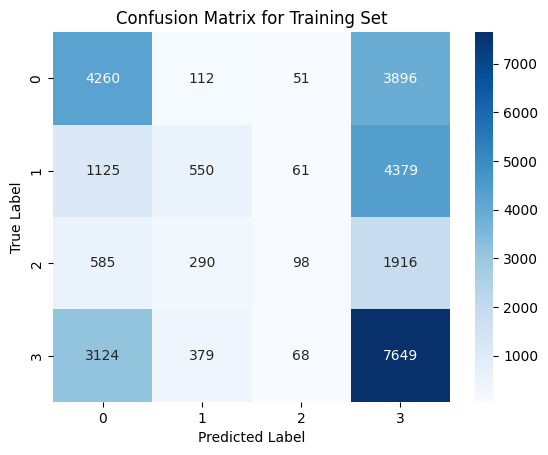

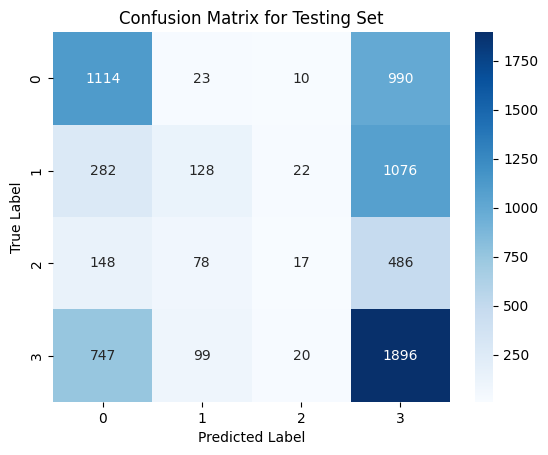

In [43]:
print("Train:")
print(classification_report(yTrain.argmax(axis=1), ensemble_simple_train_labels, zero_division=0))
print("Test:")
print(classification_report(yTest.argmax(axis=1), ensemble_simple_test_labels, zero_division=0))

yTrain_labels = yTrain.argmax(axis=1)
cf1 = confusion_matrix(yTrain_labels, ensemble_simple_train_labels)
sns.heatmap(cf1, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Training Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

yTest_labels = yTest.argmax(axis=1)
cf1 = confusion_matrix(yTest_labels, ensemble_simple_test_labels)
sns.heatmap(cf1, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Testing Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [40]:


lin1_train_labels = linmodel1_train_pred.argmax(axis=1)
lin2_train_labels = linmodel2_train_pred.argmax(axis=1)
lin3_train_labels = linmodel3_train_pred.argmax(axis=1)

lin1_test_labels = linmodel1_test_pred.argmax(axis=1)
lin2_test_labels = linmodel2_test_pred.argmax(axis=1)
lin3_test_labels = linmodel3_test_pred.argmax(axis=1)

lin1_train_accuracy = accuracy_score(yTrain.argmax(axis=1), lin1_train_labels)
lin2_train_accuracy = accuracy_score(yTrain.argmax(axis=1), lin2_train_labels)
lin3_train_accuracy = accuracy_score(yTrain.argmax(axis=1), lin3_train_labels)

lin1_test_accuracy = accuracy_score(yTest.argmax(axis=1), lin1_test_labels)
lin2_test_accuracy = accuracy_score(yTest.argmax(axis=1), lin2_test_labels)
lin3_test_accuracy = accuracy_score(yTest.argmax(axis=1), lin3_test_labels)

ensemble_simple_train_accuracy = accuracy_score(yTrain.argmax(axis=1), ensemble_simple_train_labels)
ensemble_simple_test_accuracy = accuracy_score(yTest.argmax(axis=1), ensemble_simple_test_labels)

print("Model Train Accuracies:")
print(f"LR 1: {lin1_train_accuracy:.4f}")
print(f"LR 2: {lin2_train_accuracy:.4f}")
print(f"LR 3: {lin3_train_accuracy:.4f}")
print()

print("Model Test Accuracies:")
print(f"LR 1: {lin1_test_accuracy:.4f}")
print(f"LR 2: {lin2_test_accuracy:.4f}")
print(f"LR 3: {lin3_test_accuracy:.4f}")
print()

print("Ensemble Model:")
print(f"Training Accuracy: {ensemble_simple_train_accuracy:.4f}")
print(f"Testing Accuracy: {ensemble_simple_test_accuracy:.4f}")

if ensemble_simple_test_accuracy > ensemble_simple_train_accuracy:
    print("There could be overfitting.")
else:
    print("There should be no overfitting.")

Model Train Accuracies:
LR 1: 0.4404
LR 2: 0.4398
LR 3: 0.4394

Model Test Accuracies:
LR 1: 0.4413
LR 2: 0.4421
LR 3: 0.4423

Ensemble Model:
Training Accuracy: 0.4399
Testing Accuracy: 0.4421
There could be overfitting.


## Medium Ensemble: 2 NN + 1 Linear

In [41]:
# Convert ridge predictions to probabilities using softmax
ridge_train_prob = np.exp(linmodel1_train_pred) / np.sum(np.exp(linmodel1_train_pred), axis=1, keepdims=True)
ridge_test_prob = np.exp(linmodel1_test_pred) / np.sum(np.exp(linmodel1_test_pred), axis=1, keepdims=True)

ensemble_medium_train_pred = (nn1_train_pred + nn2_train_pred + linmodel1_train_pred) / 3
ensemble_medium_test_pred = (nn1_test_pred + nn2_test_pred + linmodel1_test_pred) / 3

ensemble_medium_train_labels = ensemble_medium_train_pred.argmax(axis=1)
ensemble_medium_test_labels = ensemble_medium_test_pred.argmax(axis=1)

## (Medium Ensemble) Evaluation

Train:
              precision    recall  f1-score   support

           0       0.47      0.51      0.49      8319
           1       0.41      0.09      0.15      6115
           2       0.35      0.03      0.06      2889
           3       0.43      0.68      0.53     11220

    accuracy                           0.44     28543
   macro avg       0.42      0.33      0.31     28543
weighted avg       0.43      0.44      0.39     28543

Test:
              precision    recall  f1-score   support

           0       0.49      0.52      0.50      2137
           1       0.39      0.08      0.14      1508
           2       0.25      0.02      0.04       729
           3       0.43      0.69      0.53      2762

    accuracy                           0.44      7136
   macro avg       0.39      0.33      0.30      7136
weighted avg       0.42      0.44      0.39      7136



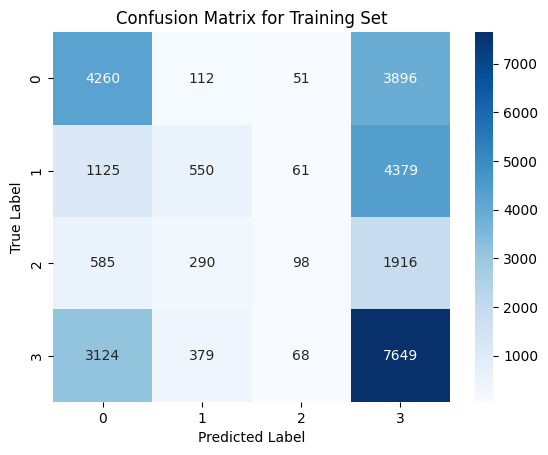

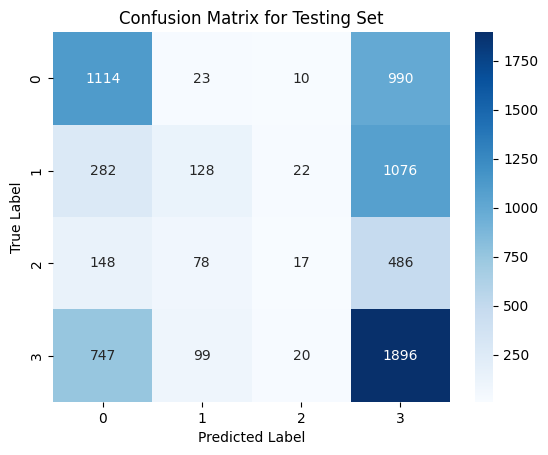

In [44]:
print("Train:")
print(classification_report(yTrain.argmax(axis=1), ensemble_medium_train_labels, zero_division=0))
print("Test:")
print(classification_report(yTest.argmax(axis=1), ensemble_medium_test_labels, zero_division=0))

yTrain_labels = yTrain.argmax(axis=1)
ensemble_medium_train_labels = ensemble_simple_train_pred.argmax(axis=1)
cf1 = confusion_matrix(yTrain_labels, ensemble_medium_train_labels)
sns.heatmap(cf1, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Training Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

yTest_labels = yTest.argmax(axis=1)
ensemble_medium_test_labels = ensemble_simple_test_pred.argmax(axis=1)
cf1 = confusion_matrix(yTest_labels, ensemble_medium_test_labels)
sns.heatmap(cf1, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Testing Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [45]:
lin1_train_labels = linmodel1_train_pred.argmax(axis=1)
lin2_train_labels = linmodel2_train_pred.argmax(axis=1)

lin1_test_labels = linmodel1_test_pred.argmax(axis=1)
lin2_test_labels = linmodel2_test_pred.argmax(axis=1)

lin1_train_accuracy = accuracy_score(yTrain.argmax(axis=1), lin1_train_labels)
lin2_train_accuracy = accuracy_score(yTrain.argmax(axis=1), lin2_train_labels)
nn1_train_accuracy = accuracy_score(yTrain.argmax(axis=1), nn1_train_labels)

lin1_test_accuracy = accuracy_score(yTest.argmax(axis=1), lin1_test_labels)
lin2_test_accuracy = accuracy_score(yTest.argmax(axis=1), lin2_test_labels)
nn1_test_accuracy = accuracy_score(yTest.argmax(axis=1), nn1_test_labels)

ensemble_medium_train_accuracy = accuracy_score(yTrain.argmax(axis=1), ensemble_medium_train_labels)
ensemble_medium_test_accuracy = accuracy_score(yTest.argmax(axis=1), ensemble_medium_test_labels)

print("Model Train Accuracies:")
print(f"LR 1: {lin1_train_accuracy:.4f}")
print(f"LR 2: {lin2_train_accuracy:.4f}")
print(f"NN : {nn1_train_accuracy:.4f}")
print()

print("Model Test Accuracies:")
print(f"LR 1: {lin1_test_accuracy:.4f}")
print(f"LR 2: {lin2_test_accuracy:.4f}")
print(f"NN : {nn1_test_accuracy:.4f}")
print()

print("Ensemble Model:")
print(f"Training Accuracy: {ensemble_medium_train_accuracy:.4f}")
print(f"Testing Accuracy: {ensemble_medium_test_accuracy:.4f}")

if ensemble_simple_test_accuracy > ensemble_simple_train_accuracy:
    print("There could be overfitting.")
else:
    print("There should be no overfitting.")

Model Train Accuracies:
LR 1: 0.4404
LR 2: 0.4398
NN : 0.4589

Model Test Accuracies:
LR 1: 0.4413
LR 2: 0.4421
NN : 0.4434

Ensemble Model:
Training Accuracy: 0.4399
Testing Accuracy: 0.4421
There could be overfitting.


## Complex Ensemble: 2 NN + 1 RF

In [46]:
ensemble_train_pred = (nn1_train_pred + nn2_train_pred + RF_train_pred) / 3
ensemble_test_pred = (nn1_test_pred + nn2_test_pred + RF_test_pred) / 3

ensemble_train_labels = ensemble_train_pred.argmax(axis=1)
ensemble_test_labels = ensemble_test_pred.argmax(axis=1)

print("ensemble_train_labels:",ensemble_train_labels)
print("ensemble_train_labels:",ensemble_train_labels)


ensemble_train_labels: [3 1 3 ... 0 3 3]
ensemble_train_labels: [3 1 3 ... 0 3 3]


## (Complex Ensemble) Test

Train:
              precision    recall  f1-score   support

           0       0.80      0.92      0.86      8319
           1       0.95      0.70      0.81      6115
           2       1.00      0.50      0.67      2889
           3       0.82      0.95      0.88     11220

    accuracy                           0.84     28543
   macro avg       0.89      0.77      0.80     28543
weighted avg       0.86      0.84      0.83     28543

Test:
              precision    recall  f1-score   support

           0       0.49      0.58      0.53      2137
           1       0.47      0.14      0.22      1508
           2       0.28      0.05      0.08       729
           3       0.43      0.64      0.52      2762

    accuracy                           0.45      7136
   macro avg       0.42      0.35      0.34      7136
weighted avg       0.44      0.45      0.41      7136



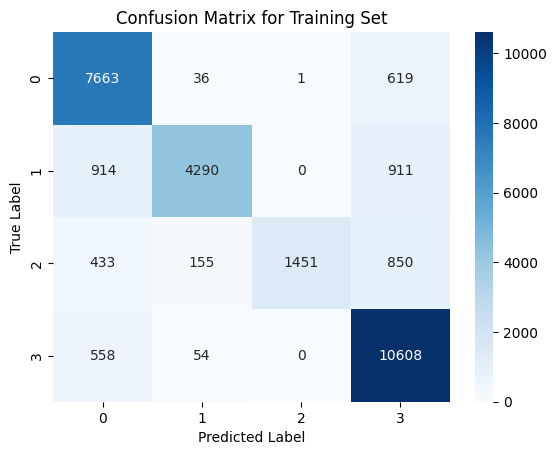

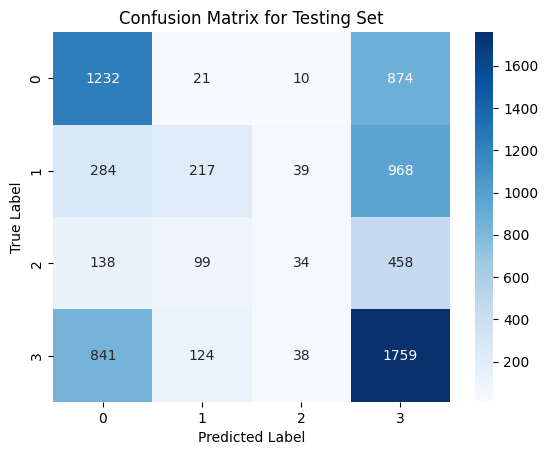

In [47]:
print("Train:")
print(classification_report(yTrain.argmax(axis=1), ensemble_train_labels))
print("Test:")
print(classification_report(yTest.argmax(axis=1), ensemble_test_labels))

yTrain_labels = yTrain.argmax(axis=1)
cf1 = confusion_matrix(yTrain_labels, ensemble_train_labels)
sns.heatmap(cf1, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Training Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

yTest_labels = yTest.argmax(axis=1)
cf1 = confusion_matrix(yTest_labels, ensemble_test_labels)
sns.heatmap(cf1, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Testing Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [ ]:
nn1_train_accuracy = accuracy_score(yTrain.argmax(axis=1), nn1_train_labels)
nn2_train_accuracy = accuracy_score(yTrain.argmax(axis=1), nn2_train_labels)
RF_train_accuracy = accuracy_score(yTrain.argmax(axis=1), RF_train_labels)

nn1_test_accuracy = accuracy_score(yTest.argmax(axis=1), nn1_test_labels)
nn2_test_accuracy = accuracy_score(yTest.argmax(axis=1), nn2_test_labels)
RF_test_accuracy = accuracy_score(yTest.argmax(axis=1), RF_test_labels)

ensemble_train_accuracy = accuracy_score(yTrain.argmax(axis=1), ensemble_train_labels)
ensemble_test_accuracy = accuracy_score(yTest.argmax(axis=1), ensemble_test_labels)

print("Model Train Accuracies:")
print(f"Neural Network 1: {nn1_train_accuracy:.4f}")
print(f"Neural Network 2: {nn2_train_accuracy:.4f}")
print(f"Random Forest: {RF_train_accuracy:.4f}")
print()

print("Model Test Accuracies:")
print(f"Neural Network 1: {nn1_test_accuracy:.4f}")
print(f"Neural Network 2: {nn2_test_accuracy:.4f}")
print(f"Random Forest: {RF_test_accuracy:.4f}")
print()

print("Ensemble Model:")
print(f"Training Accuracy: {ensemble_train_accuracy:.4f}")
print(f"Testing Accuracy: {ensemble_test_accuracy:.4f}")

if ensemble_test_accuracy > ensemble_train_accuracy:
    print("There could be overfitting.")
else:
    print("There should be no overfitting.")

Model Train Accuracies:
Neural Network 1: 0.4697
Neural Network 2: 0.4653
Random Forest: 1.0000

Model Test Accuracies:
Neural Network 1: 0.4489
Neural Network 2: 0.4439
Random Forest: 0.4517

Ensemble Model:
Training Accuracy: 0.8530
Testing Accuracy: 0.4561
There should be no overfitting.


## Stratified KFold + Complex Ensemble Evaluation

In [13]:
# Initialize empty lists to store trained models
nn1_models, nn2_models, rf_models, ridge1_models, ridge2_models, ridge3_models = [], [], [], [], [], []

# Define StratifiedKFold instance
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)

mirror_strategy = tf.distribute.MirroredStrategy()

for train_index, test_index in skf.split(x, y.argmax(axis=1)):
    xTrain_fold, xTest_fold = x.iloc[train_index].values, x.iloc[test_index].values
    yTrain_fold, yTest_fold = y[train_index], y[test_index]

    # Scale data after splitting
    scaler = MinMaxScaler()
    xTrain_fold = scaler.fit_transform(xTrain_fold)
    xTest_fold = scaler.transform(xTest_fold)  # Important: transform only using the train data scaling parameters

    # Neural Network Training within the mirror_strategy scope
    with mirror_strategy.scope():
        nn_model1 = build_nn_model(xTrain_fold.shape[1:], yTrain_fold.shape[1])
        nn_model2 = build_nn_model(xTrain_fold.shape[1:], yTrain_fold.shape[1])

        nn_model1.fit(xTrain_fold, yTrain_fold, epochs=10, verbose=0)
        nn_model2.fit(xTrain_fold, yTrain_fold, epochs=10, verbose=0)

    # Random Forest Training
    RF_model = RandomForestClassifier(n_estimators=100)
    RF_model.fit(xTrain_fold, yTrain_fold.argmax(axis=1))

    # Ridge Regression Training
    linmodel_1 = Ridge(alpha=0.01)
    linmodel_2 = Ridge(alpha=0.3)
    linmodel_3 = Ridge(alpha=0.5)
    linmodel_1.fit(xTrain_fold, yTrain_fold)
    linmodel_2.fit(xTrain_fold, yTrain_fold)
    linmodel_3.fit(xTrain_fold, yTrain_fold)

    # Store trained models
    nn1_models.append(nn_model1)
    nn2_models.append(nn_model2)
    rf_models.append(RF_model)
    ridge1_models.append(linmodel_1)
    ridge2_models.append(linmodel_2)
    ridge3_models.append(linmodel_3)


Complex model average train and test accuracy

223/223 [==============================] - 1s 3ms/step
Complex Ensemble Model:
Training Accuracy: 0.7028
Testing Accuracy: 0.7010


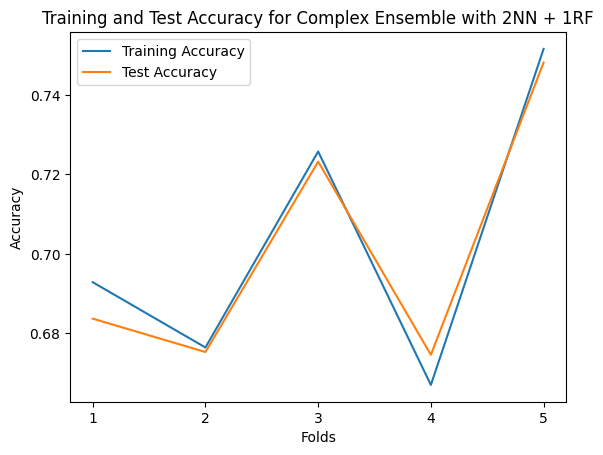

In [24]:
def complex_ensemble_accuracy(nn1_models, nn2_models, rf_models):

    train_accuracies = []
    test_accuracies = []

    for i in range(5):
        # Train metrics
        nn1_train_pred = nn1_models[i].predict(scale_xTrain)
        nn2_train_pred = nn2_models[i].predict(scale_xTrain)
        RF_train_pred = rf_models[i].predict_proba(scale_xTrain)

        ensemble_train_pred = (nn1_train_pred + nn2_train_pred + RF_train_pred) / 3
        ensemble_train_labels = ensemble_train_pred.argmax(axis=1)

        train_acc = accuracy_score(yTrain.argmax(axis=1), ensemble_train_labels)
        train_accuracies.append(train_acc)

        # Test metrics
        nn1_test_pred = nn1_models[i].predict(scale_xTest)
        nn2_test_pred = nn2_models[i].predict(scale_xTest)
        RF_test_pred = rf_models[i].predict_proba(scale_xTest)

        ensemble_test_pred = (nn1_test_pred + nn2_test_pred + RF_test_pred) / 3
        ensemble_test_labels = ensemble_test_pred.argmax(axis=1)

        test_acc = accuracy_score(yTest.argmax(axis=1), ensemble_test_labels)
        test_accuracies.append(test_acc)

    return train_accuracies, test_accuracies

# Compute average train and test accuracies for the complex ensemble
complex_ensemble_train_acc, complex_ensemble_test_acc = complex_ensemble_accuracy(nn1_models, nn2_models, rf_models)

#Avearage of train and test accuracies
avg_train_acc = np.mean(complex_ensemble_train_acc)
avg_test_acc = np.mean(complex_ensemble_test_acc)

print("Complex Ensemble Model:")
print(f"Training Accuracy: {avg_train_acc:.4f}")
print(f"Testing Accuracy: {avg_test_acc:.4f}")

#Plot train against test acc across the folds
plt.plot(complex_ensemble_train_acc, label='Training Accuracy')
plt.plot(complex_ensemble_test_acc, label='Test Accuracy')
plt.title('Training and Test Accuracy for Complex Ensemble with 2NN + 1RF')
plt.xlabel('Folds')
plt.xticks(list(range(5)), [f"{i+1}" for i in range(5)])
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Medium Ensemble Average Train and Test Acc

223/223 [==============================] - 1s 3ms/step
Medium Ensemble Model with Ridge1:
Training Accuracy: 0.4676
Testing Accuracy: 0.4642


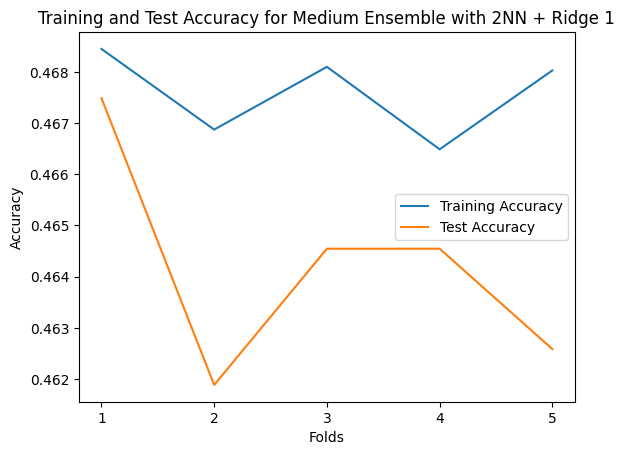

223/223 [==============================] - 1s 3ms/step
Medium Ensemble Model with Ridge2:
Training Accuracy: 0.4675
Testing Accuracy: 0.4641


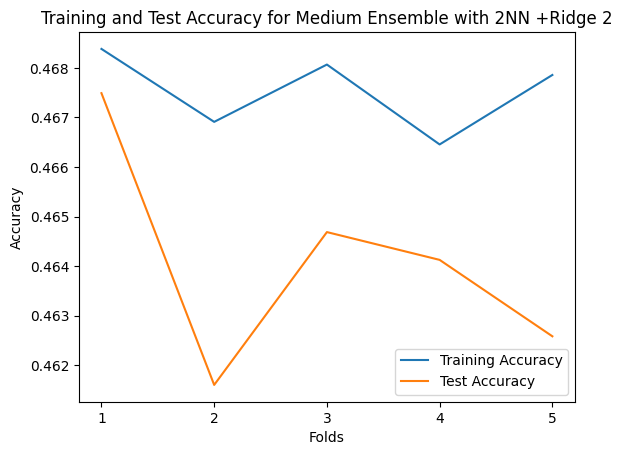

223/223 [==============================] - 1s 4ms/step
Medium Ensemble Model with Ridge3:
Training Accuracy: 0.4676
Testing Accuracy: 0.4641


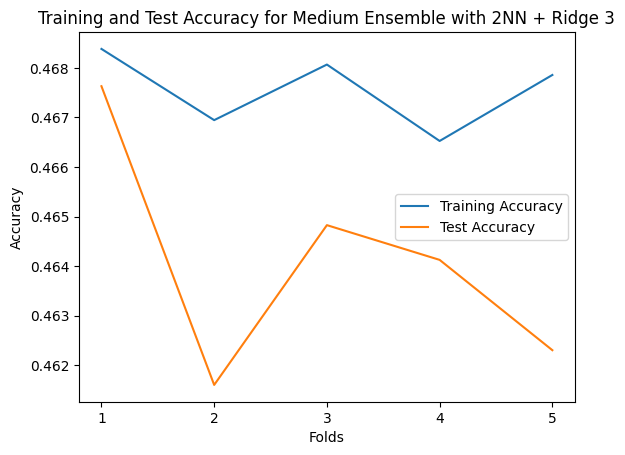

In [23]:
def medium_ensemble_accuracy(nn1_models, nn2_models, ridge_models):
    train_accuracies = []
    test_accuracies = []

    for i in range(5):
        # Train metrics
        nn1_train_pred = nn1_models[i].predict(scale_xTrain)
        nn2_train_pred = nn2_models[i].predict(scale_xTrain)
        ridge_train_pred = ridge_models[i].predict(scale_xTrain)

        # Convert ridge predictions to probabilities using softmax
        ridge_train_prob = np.exp(ridge_train_pred) / np.sum(np.exp(ridge_train_pred), axis=1, keepdims=True)

        ensemble_train_pred = (nn1_train_pred + nn2_train_pred + ridge_train_prob) / 3
        ensemble_train_labels = ensemble_train_pred.argmax(axis=1)

        train_acc = accuracy_score(yTrain.argmax(axis=1), ensemble_train_labels)
        train_accuracies.append(train_acc)

        # Test metrics
        nn1_test_pred = nn1_models[i].predict(scale_xTest)
        nn2_test_pred = nn2_models[i].predict(scale_xTest)
        ridge_test_pred = ridge_models[i].predict(scale_xTest)

        # Convert ridge predictions to probabilities using softmax
        ridge_test_prob = np.exp(ridge_test_pred) / np.sum(np.exp(ridge_test_pred), axis=1, keepdims=True)

        ensemble_test_pred = (nn1_test_pred + nn2_test_pred + ridge_test_prob) / 3
        ensemble_test_labels = ensemble_test_pred.argmax(axis=1)

        test_acc = accuracy_score(yTest.argmax(axis=1), ensemble_test_labels)
        test_accuracies.append(test_acc)

    return train_accuracies, test_accuracies

# Compute average train and test accuracies for the medium ensemble with Ridge 1 (alpha = 0.01)
medium_ensemble_train_acc_1, medium_ensemble_test_acc_1 = medium_ensemble_accuracy(nn1_models, nn2_models, ridge1_models)
# Average of train and test accuracies
avg_train_acc = np.mean(medium_ensemble_train_acc_1)
avg_test_acc = np.mean(medium_ensemble_test_acc_1)

print("Medium Ensemble Model with Ridge1:")
print(f"Training Accuracy: {avg_train_acc:.4f}")
print(f"Testing Accuracy: {avg_test_acc:.4f}")
print("\n")

plt.plot(medium_ensemble_train_acc_1, label='Training Accuracy')
plt.plot(medium_ensemble_test_acc_1, label='Test Accuracy')
plt.title('Training and Test Accuracy for Medium Ensemble with 2NN + Ridge 1')
plt.xlabel('Folds')
plt.xticks(list(range(5)), [f"{i+1}" for i in range(5)])
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Compute average train and test accuracies for the medium ensemble with Ridge 1 (alpha = 0.3)
medium_ensemble_train_acc_2, medium_ensemble_test_acc_2 = medium_ensemble_accuracy(nn1_models, nn2_models, ridge2_models)
# Average of train and test accuracies
avg_train_acc2 = np.mean(medium_ensemble_train_acc_2)
avg_test_acc2 = np.mean(medium_ensemble_test_acc_2)

print("Medium Ensemble Model with Ridge2:")
print(f"Training Accuracy: {avg_train_acc2:.4f}")
print(f"Testing Accuracy: {avg_test_acc2:.4f}")

plt.plot(medium_ensemble_train_acc_2, label='Training Accuracy')
plt.plot(medium_ensemble_test_acc_2, label='Test Accuracy')
plt.title('Training and Test Accuracy for Medium Ensemble with 2NN +Ridge 2')
plt.xlabel('Folds')
plt.xticks(list(range(5)), [f"{i+1}" for i in range(5)])
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Compute average train and test accuracies for the medium ensemble with Ridge 1 (alpha = 0.5)
medium_ensemble_train_acc_3, medium_ensemble_test_acc_3 = medium_ensemble_accuracy(nn1_models, nn2_models, ridge3_models)
# Average of train and test accuracies
avg_train_acc3 = np.mean(medium_ensemble_train_acc_3)
avg_test_acc3 = np.mean(medium_ensemble_test_acc_3)
print("Medium Ensemble Model with Ridge3:")
print(f"Training Accuracy: {avg_train_acc3:.4f}")
print(f"Testing Accuracy: {avg_test_acc3:.4f}")

plt.plot(medium_ensemble_train_acc_3, label='Training Accuracy')
plt.plot(medium_ensemble_test_acc_3, label='Test Accuracy')
plt.title('Training and Test Accuracy for Medium Ensemble with 2NN + Ridge 3')
plt.xlabel('Folds')
plt.xticks(list(range(5)), [f"{i+1}" for i in range(5)])
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Easy Ensemble Average Train and Test Acc

Easy Ensemble Model:
Training Accuracy: 0.4503
Testing Accuracy: 0.4427


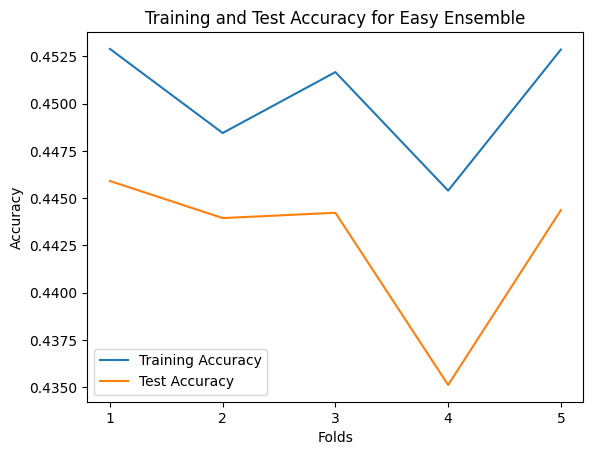

In [31]:
def easy_ensemble_accuracy(ridge1_models, ridge2_models, ridge3_models):

    train_accuracies = []
    test_accuracies = []

    for i in range(5):
        # Train metrics
        ridge1_train_pred = ridge1_models[i].predict(scale_xTrain)
        ridge2_train_pred = ridge2_models[i].predict(scale_xTrain)
        ridge3_train_pred = ridge3_models[i].predict(scale_xTrain)

        ensemble_train_pred = (ridge1_train_pred + ridge2_train_pred + ridge3_train_pred) / 3
        ensemble_train_labels = ensemble_train_pred.argmax(axis=1)

        train_acc = accuracy_score(yTrain.argmax(axis=1), ensemble_train_labels)
        train_accuracies.append(train_acc)

        # Test metrics
        ridge1_test_pred = ridge1_models[i].predict(scale_xTest)
        ridge2_test_pred = ridge2_models[i].predict(scale_xTest)
        ridge3_test_pred = ridge3_models[i].predict(scale_xTest)

        ensemble_test_pred = (ridge1_test_pred + ridge2_test_pred + ridge3_test_pred) / 3
        ensemble_test_labels = ensemble_test_pred.argmax(axis=1)

        test_acc = accuracy_score(yTest.argmax(axis=1), ensemble_test_labels)
        test_accuracies.append(test_acc)



    return train_accuracies, test_accuracies

# Compute average train and test accuracies for the easy ensemble
easy_ensemble_train_acc, easy_ensemble_test_acc = easy_ensemble_accuracy(ridge1_models, ridge2_models, ridge3_models)

# Average of train and test accuracies
avg_train_acc = np.mean(easy_ensemble_train_acc)
avg_test_acc = np.mean(easy_ensemble_test_acc)

print("Easy Ensemble Model:")
print(f"Training Accuracy: {avg_train_acc:.4f}")
print(f"Testing Accuracy: {avg_test_acc:.4f}")

# Plot train acc against test acc
plt.plot(easy_ensemble_train_acc, label='Training Accuracy')
plt.plot(easy_ensemble_test_acc, label='Test Accuracy')
plt.title('Training and Test Accuracy for Easy Ensemble')
plt.xlabel('Folds')
plt.xticks(list(range(5)), [f"{i+1}" for i in range(5)])
plt.ylabel('Accuracy')
plt.legend()
plt.show()
